In [1]:
# this is training unet from scratch
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
from time import time
import tensorflow as tf
from tensorflow import keras

In [2]:
IMAGE_SIZE = 1024
BATCH_SIZE = 4
NUM_CLASSES = 13
DATA_DIR = r"\\fatherserverdw\Q\research\images\skin_aging\deeplab_trainingset\v11_fold5"
train_images = sorted(glob(os.path.join(*[DATA_DIR, 'training',"im/*"])))
train_masks = sorted(glob(os.path.join(*[DATA_DIR, 'training',"label/*"])))
val_images = sorted(glob(os.path.join(*[DATA_DIR, 'validation',"im/*"])))
# if thumbs.db in list
val_images.remove('\\\\fatherserverdw\\Q\\research\\images\\skin_aging\\deeplab_trainingset\\v11_fold5\\validation\\im\\Thumbs.db')
val_masks = sorted(glob(os.path.join(*[DATA_DIR, 'validation',"label/*"])))

In [3]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    # image = cv2.imread(image_path.decode('UTF-8'))
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        # image[image==13]=0
        image = tf.where(tf.equal(image, 13), tf.zeros_like(image), image)
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        # image = image / 127.5 - 1 #[-1 1]
        image = image/255 #[0 1]
    return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    # dataset = dataset.map(lambda x,y: tf.numpy_function(load_data, [x,y], Tout=tf.uint8))
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [4]:
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)
print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 1024, 1024, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 1024, 1024, 1), dtype=tf.float32, name=None))>


In [5]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = tf.keras.layers.MaxPool2D(2)(f)
   p = tf.keras.layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = tf.keras.layers.concatenate([x, conv_features])
   # dropout
   x = tf.keras.layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

def UNet(image_size, num_classes):
   # inputs
   inputs = tf.keras.layers.Input(shape=(image_size, image_size, 3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = tf.keras.layers.Conv2D(num_classes, 1, padding="same")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

model = UNet(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1024, 1024,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1024, 1024,   36928       ['conv2d[0][0]']                 
                                64)                                                           

In [6]:
## Training

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    # optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=loss,
    metrics=["accuracy"],
)

checkpoint_path = "fold_5/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True,
                                                 verbose=1,
                                                 )
earlystop = keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=10,
        verbose=1,
    )

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    if epoch%2:
        return lr
    else:
        return lr * 0.1

lrschedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)
round(model.optimizer.lr.numpy(), 5)


1e-04

In [7]:
start = time()
history = model.fit(train_dataset, validation_data=val_dataset, epochs=40,callbacks=[cp_callback,earlystop,lrschedule])
print(np.around(time()-start),'seconds elapsed')
round(model.optimizer.lr.numpy(), 5)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/40
40/40 [==============================] - ETA: 0s - loss: 1.7535 - accuracy: 0.5265 
Epoch 1: val_accuracy improved from -inf to 0.56225, saving model to fold_5\cp.ckpt
40/40 [==============================] - 1877s 47s/step - loss: 1.7535 - accuracy: 0.5265 - val_loss: 1.5397 - val_accuracy: 0.5622 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/40
40/40 [==============================] - ETA: 0s - loss: 1.3692 - accuracy: 0.6000 
Epoch 2: val_accuracy improved from 0.56225 to 0.57732, saving model to fold_5\cp.ckpt
40/40 [==============================] - 1922s 48s/step - loss: 1.3692 - accuracy: 0.6000 - val_loss: 1.4208 - val_accuracy: 0.5773 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/40
40/40 [==============================] - ETA: 0s - loss: 1.3250 - accuracy: 0.6020 
Epoch 

0.0

In [8]:
print(val_dataset)
y = model.predict(val_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(4, 1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 1024, 1024, 1), dtype=tf.float32, name=None))>


(48, 1024, 1024, 13)
[ 0  1  2  3  4  6  7  8  9 10 11 12]


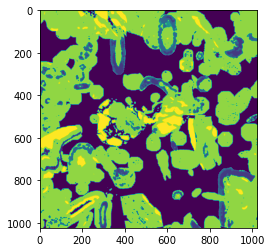

In [9]:
print(y.shape)
pred_mask = tf.argmax(y[1], axis=-1)
print(np.unique(pred_mask))
plt.imshow(pred_mask)

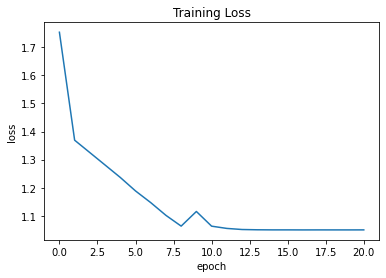

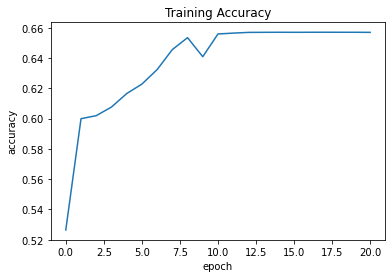

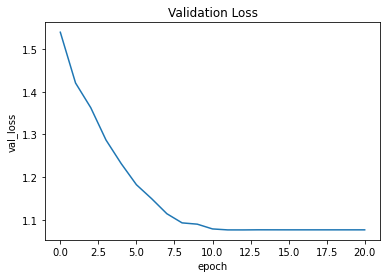

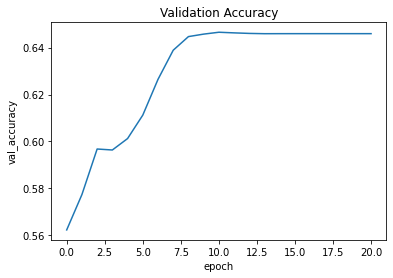

In [15]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()